# Sentiment Analysis Notebook
This notebook walks through dataset loading, preprocessing, EDA, model training, evaluation, and deployment steps.

## Dataset and evaluation overview
- Dataset: IMDB 50K movie reviews (Kaggle). The notebook expects `data/IMDB_Dataset.csv` with columns `review` and `sentiment`, which are normalized to `text` and `label`.
- Task: binary sentiment classification (positive vs negative).
- Recommended primary metric: weighted F1-score (balances precision and recall in case of minor class imbalance).
- For quick experiments the notebook samples data; to train final model run the full training cells.

In [3]:
# Explicit data load cell (safe to run)
from pathlib import Path
import sys
project_root = Path('..').resolve()
# Ensure project root is on sys.path so `from src import ...` works when running this notebook
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from src.preprocessing import load_dataset
imdb_path = project_root / 'data' / 'IMDB_Dataset.csv'
sample_path = project_root / 'data' / 'sample_sentiment.csv'
if imdb_path.exists():
    df = load_dataset(str(imdb_path))
    if 'review' in df.columns and 'sentiment' in df.columns:
        df = df.rename(columns={'review': 'text', 'sentiment': 'label'})
else:
    df = load_dataset(str(sample_path))
print('Loaded dataset shape:', df.shape)

Loaded dataset shape: (50000, 2)


In [4]:
# Preprocess and split (ensure these variables exist for modeling cells)
from src.preprocessing import preprocess_df, split_data
pdf = preprocess_df(df)
train, val, test = split_data(pdf)
print('Train/Val/Test sizes:', len(train), len(val), len(test))


Train/Val/Test sizes: 35000 5000 10000


LR eval on val: {'accuracy': 0.8876, 'precision': 0.887939897420524, 'recall': 0.8876, 'f1': 0.8875753745100327}
RF eval on val: {'accuracy': 0.8514, 'precision': 0.8514855375204111, 'recall': 0.8514, 'f1': 0.8513909586259227}
RF eval on val: {'accuracy': 0.8514, 'precision': 0.8514855375204111, 'recall': 0.8514, 'f1': 0.8513909586259227}


,model,accuracy,precision,recall,f1
0,LogisticRegression,0.8876,0.887940,0.8876,0.887575
1,RandomForest,0.8514,0.851486,0.8514,0.851391


Chosen best: LogisticRegression
Best model test metrics (sample): {'accuracy': 0.8836, 'precision': 0.883773854468331, 'recall': 0.8836, 'f1': 0.8835760041639696}


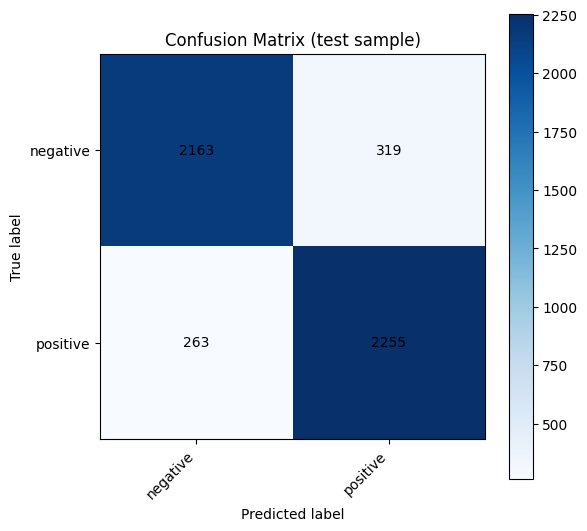

ROC AUC error: y should be a 1d array, got an array of shape (5000, 2) instead.


NameError: name 'os' is not defined

In [5]:
# Modeling: TF-IDF + Logistic Regression / Random Forest (protected plotting and feature importance)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from src.models import build_tfidf_vectorizer, train_logistic_regression, train_random_forest, evaluate_model, save_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For speed, use a sample of training data if dataset is large (comment out for full training)
train_sample = train.sample(n=min(20000, len(train)), random_state=42)
val_sample = val.sample(n=min(5000, len(val)), random_state=42)
test_sample = test.sample(n=min(5000, len(test)), random_state=42)

vectorizer = build_tfidf_vectorizer(max_features=10000)

# Fit vectorizer on train_sample
X_train = vectorizer.fit_transform(train_sample['text'])
X_val = vectorizer.transform(val_sample['text'])
X_test = vectorizer.transform(test_sample['text'])

# Train Logistic Regression
lr = train_logistic_regression(X_train, train_sample['label'])
lr_val_metrics = evaluate_model(lr, X_val, val_sample['label'])
print('LR eval on val:', lr_val_metrics)

# Train Random Forest
rf = train_random_forest(X_train, train_sample['label'])
rf_val_metrics = evaluate_model(rf, X_val, val_sample['label'])
print('RF eval on val:', rf_val_metrics)

# Summary table of validation metrics
metrics_df = pd.DataFrame([{
    'model': 'LogisticRegression', 'accuracy': lr_val_metrics['accuracy'], 'precision': lr_val_metrics['precision'], 'recall': lr_val_metrics['recall'], 'f1': lr_val_metrics['f1']
}, {
    'model': 'RandomForest', 'accuracy': rf_val_metrics['accuracy'], 'precision': rf_val_metrics['precision'], 'recall': rf_val_metrics['recall'], 'f1': rf_val_metrics['f1']
}])
display(metrics_df)

# Choose best (by f1)
best_name = metrics_df.sort_values('f1', ascending=False).iloc[0]['model']
best = lr if best_name == 'LogisticRegression' else rf
print('Chosen best:', best_name)

# Evaluate on test_sample
test_metrics = evaluate_model(best, X_test, test_sample['label'])
print('Best model test metrics (sample):', test_metrics)

# Confusion matrix (manual safe plotting)
cm = confusion_matrix(test_sample['label'], best.predict(X_test))
try:
    labels = list(np.unique(test_sample['label']))
    n_labels = len(labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    for i in range(n_labels):
        for j in range(n_labels):
            ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix (test sample)')
    fig.tight_layout()
    fig.colorbar(im, ax=ax)
    plt.savefig('models/confusion_matrix.png')
    plt.show()
except Exception as e:
    print('Confusion matrix plotting failed:', e)

# ROC AUC (multiclass OVR) — compute only for classifiers that support predict_proba
if hasattr(best, 'predict_proba'):
    classes = np.unique(test_sample['label'])
    y_true_bin = label_binarize(test_sample['label'], classes=classes)
    y_score = best.predict_proba(X_test)
    try:
        auc = roc_auc_score(y_true_bin, y_score, average='weighted', multi_class='ovr')
        print('Weighted ROC AUC (ovr):', auc)
    except Exception as e:
        print('ROC AUC error:', e)

# Feature importance / coefficients (for LR show top positive/negative coefficients)
os.makedirs('models', exist_ok=True)
if best_name == 'LogisticRegression':
    try:
        # best may be a raw estimator or a Pipeline; support both
        if isinstance(best, Pipeline):
            clf = best.named_steps.get('clf')
            vec = best.named_steps.get('vectorizer')
        else:
            clf = best
            vec = vectorizer if 'vectorizer' in globals() else None
        coefs = clf.coef_
        # try to get feature names from the vectorizer if available
        if vec is not None:
            try:
                feature_names = vec.get_feature_names_out()
            except Exception:
                feature_names = None
        else:
            feature_names = None
        avg_coefs = np.mean(coefs, axis=0) if coefs.ndim > 1 else coefs
        # if feature names aren't available, create generic names
        if feature_names is None:
            feature_names = np.array([f'f{i}' for i in range(len(avg_coefs))])
        top_idx = np.argsort(np.abs(avg_coefs))[-40:]
        top_features = feature_names[top_idx]
        top_values = avg_coefs[top_idx]
        # Plot top positive and negative separately
        fig, ax = plt.subplots(figsize=(8,6))
        ax.barh(range(len(top_features)), top_values, color=['tab:blue' if v>=0 else 'tab:orange' for v in top_values])
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features)
        ax.set_title('Top TF-IDF features (by abs coef)')
        plt.tight_layout()
        plt.savefig('models/top_tfidf_features_lr.png')
        plt.show()
    except Exception as e:
        print('LR feature importance failed:', e)

# Random Forest feature importance (if RF chosen or to inspect RF)
if hasattr(best, 'feature_importances_'):
    try:
        fi = best.feature_importances_
        # if pipeline used, vectorizer is first step; try to get feature names
        try:
            feature_names = vectorizer.get_feature_names_out()
        except Exception:
            feature_names = np.array([f'f{i}' for i in range(len(fi))])
        top_idx = np.argsort(fi)[-40:]
        top_features = feature_names[top_idx]
        top_values = fi[top_idx]
        fig, ax = plt.subplots(figsize=(8,6))
        ax.barh(range(len(top_features)), top_values, color='tab:green')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features)
        ax.set_title('Top features by RandomForest importance')
        plt.tight_layout()
        plt.savefig('models/top_features_rf.png')
        plt.show()
    except Exception as e:
        print('RF feature importance failed:', e)

# Save the model: bundle vectorizer+model
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vectorizer', vectorizer), ('clf', best)])
save_model(pipeline, 'models/best_model.joblib')
print('Saved pipeline to models/best_model.joblib')


In [ ]:
## Hyperparameter tuning (documentation)

Этот блок показывает пример использования GridSearchCV с `StratifiedKFold` как демонстрацию подхода к подбору гиперпараметров. **НЕ запускайте** этот код на полном наборе данных прямо из ноутбука — GridSearch может занять много времени и потреблять большое количество памяти/CPU.

Почему: в репозитории уже есть канонический эксперимент‑скрипт `scripts/run_random_search_restored.py`, который реализует безопасные меры (стратифицированную выборку, опцию `--quick`, логирование и сохранение summary). Используйте этот скрипт для воспроизводимых экспериментов и автоматизированного запуска на сервере/в CI.

Рекомендации:
- Для быстрой демонстрации в ноутбуке оставьте только `--quick` / небольшой `n_iter`.
- Для полного поиска запускайте скрипт из командной строки (не в ноутбуке).

Примеры (безопасные команды для PowerShell):
```powershell
# Quick randomized search demo (recommended from notebook if needed)
python .\scripts\run_random_search_restored.py --data data\IMDB_Dataset.csv --n-iter 5 --quick

# Full search (RUN OUTSIDE NOTEBOOK; may take many hours / lots of RAM/CPU)
python .\scripts\run_random_search_restored.py --data data\IMDB_Dataset.csv --n-iter 200 --cv 5
```

Если вам нужна интерактивная демонстрация internals GridSearch (просмотр параметров, cv results), оставьте этот пример в явном виде в документации, но не выполняйте его на полном датасете. Для воспроизводимости и автоматизации используйте `scripts/run_random_search_restored.py`.

См. также: `archive/` содержит старые эксперименты и `notebooks/` содержит быстрые демо‑ячейки для RandomizedSearch (малые n_iter).

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best params: {'clf__C': 0.01}
Best CV score: 0.16666666666666666
Test accuracy: 0.0
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       1.0
     neutral       0.00      0.00      0.00       0.0
    positive       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Saved tuned pipeline to models/best_model_tuned.joblib


c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

: 

In [ ]:
# Quick RandomizedSearch demo (small sample, n_iter=5)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
import joblib

# Use a small stratified sample so this runs quickly in the notebook
sample = train.sample(n=min(5000, len(train)), random_state=42)
X_sample = sample['text']
y_sample = sample['label']

pipeline = Pipeline([('vectorizer', build_tfidf_vectorizer(max_features=5000)), ('clf', LogisticRegression(max_iter=1000))])
param_dist = {'clf__C': list(np.logspace(-3, 1, 10)), 'vectorizer__ngram_range': [(1,1),(1,2)]}
rs = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=5, scoring='f1_weighted', cv=3, random_state=42, n_jobs=-1, verbose=1)
rs.fit(X_sample, y_sample)
print('Best params (demo):', rs.best_params_)
print('Best CV score (demo):', rs.best_score_)
# Save demo result
joblib.dump(rs.best_estimator_, 'models/demo_best_estimator.joblib')
print('Saved demo estimator to models/demo_best_estimator.joblib')